# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data access

In [81]:
#load everything
stamps_dataset_5 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/5stamps_dataset.pkl')
stamp_dataset_21 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/stamp_dataset_21_new.pkl')
stamp_dataset_28 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/stamp_dataset_28.pkl')
stamp_dataset_45 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/stamp_dataset_45.pkl')
stamp_dataset_jun_allwise_45_final = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/stamp_dataset_jun_allwise_45_final.pkl')
stamp_dataset_only_images_63 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/stamp_dataset_only_images_63.pkl')
td_ztf_stamp_17_06_20 = pd.read_pickle(r'/home/pascual/inteli/proyecto/data/td_ztf_stamp_17_06_20.pkl')

## Data Characterization

In [89]:
from anytree import Node, RenderTree

# stamps_dataset_5
root = Node("stamps_dataset_5")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("labels", parent=train)
science = Node("science", parent=train)
template = Node("template", parent=train)
difference = Node("difference", parent=train)

s_labels = Node("labels", parent=validation)
s_science = Node("science", parent=validation)
s_template = Node("template", parent=validation)
s_difference = Node("difference", parent=validation)

t_labels = Node("labels", parent=test)
t_science = Node("science", parent=test)
t_template = Node("template", parent=test)
t_difference = Node("difference", parent=test)

# Render the tree
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# stamp_dataset_21
root = Node("stamp_dataset_21")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
science = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_science = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_science = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# stamp_dataset_28
root = Node("stamp_dataset_28")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
science = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_science = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_science = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# stamp_dataset_45
root = Node("stamp_dataset_45")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
science = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_science = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_science = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# stamp_dataset_jun_allwise_45_final
root = Node("stamp_dataset_jun_allwise_45_final")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
science = Node("features", parent=train)
template = Node("oid", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_science = Node("features", parent=validation)
s_template = Node("oid", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_science = Node("features", parent=test)
t_template = Node("oid", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# stamp_dataset_only_images_63
root = Node("stamp_dataset_only_images_63")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
difference = Node("class", parent=train)

s_labels = Node("images", parent=validation)
s_difference = Node("class", parent=validation)

t_labels = Node("images", parent=test)
t_difference = Node("class", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

# td_ztf_stamp_17_06_20
root = Node("td_ztf_stamp_17_06_20")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("images", parent=train)
science = Node("features", parent=train)
difference = Node("labels", parent=train)

s_labels = Node("images", parent=validation)
s_science = Node("features", parent=validation)
s_difference = Node("labels", parent=validation)

t_labels = Node("images", parent=test)
t_science = Node("features", parent=test)
t_difference = Node("labels", parent=test)

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')
print(f'Number of samples in Train:         {td_ztf_stamp_17_06_20["Train"]["labels"].size}',
        f'\nNumber of samples in Validation:    {td_ztf_stamp_17_06_20["Validation"]["labels"].size}',
        f'\nNumber of samples in Test:          {td_ztf_stamp_17_06_20["Test"]["labels"].size}\n\n\n')
# stamp_dataset_28

# stamp_dataset_45

# stamp_dataset_jun_allwise_45_final

# stamp_dataset_only_images_63

# td_ztf_stamp_17_06_20


stamps_dataset_5
├── Train
│   ├── labels
│   ├── science
│   ├── template
│   └── difference
├── validation
│   ├── labels
│   ├── science
│   ├── template
│   └── difference
└── Test
    ├── labels
    ├── science
    ├── template
    └── difference


Number of samples in Train:         123227 
Number of samples in Validation:    600 
Number of samples in Test:          600



stamp_dataset_21
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


Number of samples in Train:         72710 
Number of samples in Validation:    500 
Number of samples in Test:          500



stamp_dataset_28
├── Train
│   ├── images
│   ├── features
│   ├── oid
│   └── class
├── validation
│   ├── images
│   ├── features
│   ├── oid
│   └── class
└── Test
    ├── images
    ├── features
    ├── oid
    └── class


Number of samples in Train:         5

## Data Fixing

In [91]:
#changing all labels to match for ease of use in the future
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

# Apply the function to all datasets
rename_labels(stamps_dataset_5, 'labels', 'class')
rename_labels(td_ztf_stamp_17_06_20, 'labels', 'class')
rename_labels(stamps_dataset_5, 'science', 'images')

In [102]:
print(  f'5stamps_dataset:',
        f'\n        Number of samples in Train:         {stamps_dataset_5["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamps_dataset_5["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamps_dataset_5["Test"]["class"].size}',
        f'\n\nstamp_dataset_21_new:',
        f'\n        Number of samples in Train:         {stamp_dataset_21["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamp_dataset_21["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamp_dataset_21["Test"]["class"].size}',
        f'\n\nstamp_dataset_28:',
        f'\n        Number of samples in Train:         {stamp_dataset_28["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamp_dataset_28["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamp_dataset_28["Test"]["class"].size}',
        f'\n\nstamp_dataset_45:',
        f'\n        Number of samples in Train:         {stamp_dataset_45["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamp_dataset_45["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamp_dataset_45["Test"]["class"].size}',
        f'\n\nstamp_dataset_jun_allwise_45_final:',
        f'\n        Number of samples in Train:         {stamp_dataset_jun_allwise_45_final["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamp_dataset_jun_allwise_45_final["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamp_dataset_jun_allwise_45_final["Test"]["class"].size}',
        f'\n\nstamp_dataset_only_images_63:',
        f'\n        Number of samples in Train:         {stamp_dataset_only_images_63["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {stamp_dataset_only_images_63["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {stamp_dataset_only_images_63["Test"]["class"].size}',
        f'\n\ntd_ztf_stamp_17_06_20:',
        f'\n        Number of samples in Train:         {td_ztf_stamp_17_06_20["Train"]["class"].size}',
        f'\n        Number of samples in Validation:    {td_ztf_stamp_17_06_20["Validation"]["class"].size}',
        f'\n        Number of samples in Test:          {td_ztf_stamp_17_06_20["Test"]["class"].size}')

5stamps_dataset: 
        Number of samples in Train:         123227 
        Number of samples in Validation:    600 
        Number of samples in Test:          600 

stamp_dataset_21_new: 
        Number of samples in Train:         72710 
        Number of samples in Validation:    500 
        Number of samples in Test:          500 

stamp_dataset_28: 
        Number of samples in Train:         50594 
        Number of samples in Validation:    500 
        Number of samples in Test:          500 

stamp_dataset_45: 
        Number of samples in Train:         50594 
        Number of samples in Validation:    500 
        Number of samples in Test:          500 

stamp_dataset_jun_allwise_45_final: 
        Number of samples in Train:         72710 
        Number of samples in Validation:    500 
        Number of samples in Test:          500 

stamp_dataset_only_images_63: 
        Number of samples in Train:         50594 
        Number of samples in Validation:    500 
  

# Data Visualization

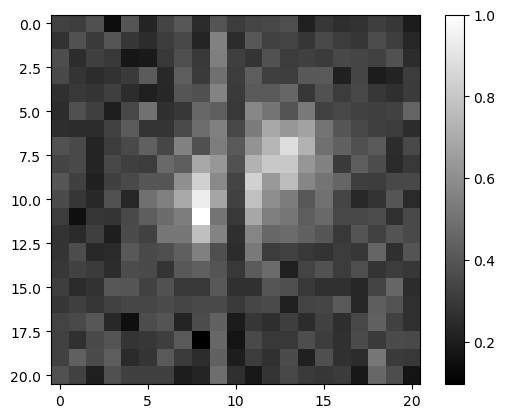

In [4]:
#image
# BEGIN: Extract and plot a 21x21 image from the dictionaries
image_21x21 = stamp_dataset_21['Train']['images'][4, :21, :21, 1]
plt.imshow(image_21x21, cmap='gray')
plt.colorbar()
plt.show()
# END: